# Lab | Making predictions with logistic regression

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

1.- Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [1]:
# installing library and engine
import pymysql
from sqlalchemy import create_engine
import pandas as pd

In [2]:
# hiding password
import getpass
password = getpass.getpass()

········


In [3]:
# defining connection
connection_string = 'mysql+pymysql://yamirt:' + password + '@127.0.0.1/sakila'
engine = create_engine(connection_string)

In [26]:
# copying created query from mysql
query = '''
SELECT 
    title,
    rental_duration,
    rental_rate,
    replacement_cost,
    length,
    MAX(rental_date) AS last_rental,
    COUNT(rental_id) AS numberofrentals,
    FLOOR(AVG(DATEDIFF(return_date, rental_date) * 24)) AS hoursrentedavg
FROM
    film
        JOIN
    inventory USING (film_id)
        JOIN
    rental USING (inventory_id)
GROUP BY title , rental_duration , rental_rate , replacement_cost , length;
'''

2.- Read the data into a Pandas dataframe.

In [31]:
#bringing the query as a dataframe
data = pd.read_sql_query(query, engine)

In [32]:
data

,title,rental_duration,rental_rate,replacement_cost,length,last_rental,numberofrentals,hoursrentedavg
0,ACADEMY DINOSAUR,6,0.99,20.99,86,2021-11-03 15:07:11,24,122
1,ACE GOLDFINGER,3,4.99,12.99,48,2006-02-14 15:16:03,7,136
2,ADAPTATION HOLES,7,2.99,18.99,50,2005-08-23 13:54:39,12,82
3,AFFAIR PREJUDICE,5,2.99,26.99,117,2006-02-14 15:16:03,23,113
4,AFRICAN EGG,6,2.99,22.99,130,2006-02-14 15:16:03,12,170
...,...,...,...,...,...,...,...,...
953,YOUNG LANGUAGE,6,0.99,9.99,183,2005-08-23 01:50:31,7,109
954,YOUTH KICK,4,0.99,14.99,179,2005-08-18 17:31:36,6,136
955,ZHIVAGO CORE,6,0.99,10.99,105,2006-02-14 15:16:03,9,141
956,ZOOLANDER FICTION,5,2.99,28.99,101,2005-08-23 08:48:43,17,134


In [33]:
# dropping the column with the 2021 date for accuracy purposes
data = data.drop(data.index[0])

In [34]:
data

,title,rental_duration,rental_rate,replacement_cost,length,last_rental,numberofrentals,hoursrentedavg
1,ACE GOLDFINGER,3,4.99,12.99,48,2006-02-14 15:16:03,7,136
2,ADAPTATION HOLES,7,2.99,18.99,50,2005-08-23 13:54:39,12,82
3,AFFAIR PREJUDICE,5,2.99,26.99,117,2006-02-14 15:16:03,23,113
4,AFRICAN EGG,6,2.99,22.99,130,2006-02-14 15:16:03,12,170
5,AGENT TRUMAN,3,2.99,17.99,169,2005-08-21 16:03:01,21,141
...,...,...,...,...,...,...,...,...
953,YOUNG LANGUAGE,6,0.99,9.99,183,2005-08-23 01:50:31,7,109
954,YOUTH KICK,4,0.99,14.99,179,2005-08-18 17:31:36,6,136
955,ZHIVAGO CORE,6,0.99,10.99,105,2006-02-14 15:16:03,9,141
956,ZOOLANDER FICTION,5,2.99,28.99,101,2005-08-23 08:48:43,17,134


3.- Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 957 entries, 1 to 957
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             957 non-null    object        
 1   rental_duration   957 non-null    int64         
 2   rental_rate       957 non-null    float64       
 3   replacement_cost  957 non-null    float64       
 4   length            957 non-null    int64         
 5   last_rental       957 non-null    datetime64[ns]
 6   numberofrentals   957 non-null    int64         
 7   hoursrentedavg    957 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 67.3+ KB


In [37]:
data.corr()

,rental_duration,rental_rate,replacement_cost,length,numberofrentals,hoursrentedavg
rental_duration,1.000000,0.031516,-0.002442,0.055584,-0.061845,0.008846
rental_rate,0.031516,1.000000,-0.048027,0.035410,-0.052129,0.009898
replacement_cost,-0.002442,-0.048027,1.000000,0.008564,0.064318,0.044589
length,0.055584,0.035410,0.008564,1.000000,-0.031544,-0.006210
numberofrentals,-0.061845,-0.052129,0.064318,-0.031544,1.000000,0.044607
hoursrentedavg,0.008846,0.009898,0.044589,-0.006210,0.044607,1.000000


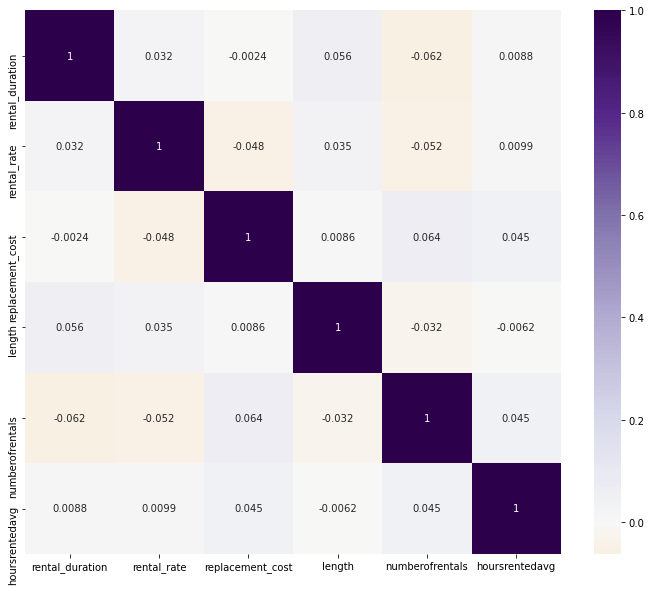

In [38]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, cmap='PuOr', center = 0);

In [39]:
import numpy as np
from sklearn.preprocessing import Normalizer

In [40]:
X = data.select_dtypes(include = np.number)

In [41]:
X.head()

,rental_duration,rental_rate,replacement_cost,length,numberofrentals,hoursrentedavg
1,3,4.99,12.99,48,7,136
2,7,2.99,18.99,50,12,82
3,5,2.99,26.99,117,23,113
4,6,2.99,22.99,130,12,170
5,3,2.99,17.99,169,21,141


In [44]:
transformer = Normalizer()
transformer.fit(X)
X_normalized = transformer.transform(X)

In [45]:
x = pd.DataFrame(X_normalized, columns = X.columns)

In [46]:
x

,rental_duration,rental_rate,replacement_cost,length,numberofrentals,hoursrentedavg
0,0.020677,0.034392,0.089530,0.330825,0.048245,0.937337
1,0.070759,0.030224,0.191960,0.505423,0.121302,0.828894
2,0.030015,0.017949,0.162023,0.702359,0.138071,0.678347
3,0.027819,0.013863,0.106594,0.602747,0.055638,0.788208
4,0.013522,0.013477,0.081085,0.761721,0.094652,0.635518
...,...,...,...,...,...,...
952,0.028111,0.004638,0.046805,0.857392,0.032796,0.510687
953,0.017745,0.004392,0.066498,0.794069,0.026617,0.603315
954,0.033998,0.005610,0.062274,0.594972,0.050998,0.798963
955,0.029200,0.017462,0.169303,0.589843,0.099281,0.782565


In [47]:
cat = data.select_dtypes(object)

In [48]:
cat

,title
1,ACE GOLDFINGER
2,ADAPTATION HOLES
3,AFFAIR PREJUDICE
4,AFRICAN EGG
5,AGENT TRUMAN
...,...
953,YOUNG LANGUAGE
954,YOUTH KICK
955,ZHIVAGO CORE
956,ZOOLANDER FICTION


In [49]:
pd.get_dummies(cat)

,title_ACE GOLDFINGER,title_ADAPTATION HOLES,title_AFFAIR PREJUDICE,title_AFRICAN EGG,title_AGENT TRUMAN,title_AIRPLANE SIERRA,title_AIRPORT POLLOCK,title_ALABAMA DEVIL,title_ALADDIN CALENDAR,title_ALAMO VIDEOTAPE,...,title_WORST BANGER,title_WRATH MILE,title_WRONG BEHAVIOR,title_WYOMING STORM,title_YENTL IDAHO,title_YOUNG LANGUAGE,title_YOUTH KICK,title_ZHIVAGO CORE,title_ZOOLANDER FICTION,title_ZORRO ARK
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
953,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
954,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
955,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


4.- Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [10]:
query2 = '''
SELECT 
    inventory_id, IF(rental_date > 20060114, 1, 0) AS rec_rental
FROM
    rental;
'''

5.- Create a logistic regression model to predict this variable from the cleaned data.

6.- Evaluate the results.